In [15]:
# === CSE 572 Recommender — all tables + plots inline (no scikit-surprise needed) ===
# Requirements (install once):  pip install pandas numpy scikit-learn matplotlib tqdm

import os, numpy as np, pandas as pd
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from IPython.display import display

In [17]:
# ---------- Config: set path if needed ----------
CANDIDATE_FILES = ["ratings small.csv", "ratings_small.csv"]
RATINGS_CSV = next((p for p in CANDIDATE_FILES if os.path.exists(p)), None)
# If None, set it manually like:
# RATINGS_CSV = "/full/path/to/ratings_small.csv"

OUT_DIR = "out"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Helpers ----------
def rmse(y_true, y_pred): return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def load_ratings(path):
    if path is None or not os.path.exists(path):
        raise FileNotFoundError("Upload 'ratings small.csv' or 'ratings_small.csv' to this folder, "
                                "or set RATINGS_CSV to its full path near the top and re-run.")
    df = pd.read_csv(path)
    df = df.rename(columns={'UserID':'userID','MovieID':'movieID'})
    need = {'userID','movieID','rating'}
    if not need.issubset(df.columns):
        raise ValueError(f"CSV must contain columns {need} (+ timestamp). Found: {list(df.columns)}")
    df = df[['userID','movieID','rating']].copy()
    df['userID'] = df['userID'].astype('category')
    df['movieID'] = df['movieID'].astype('category')
    df['rating']  = df['rating'].astype(float)
    return df

def build_maps(train_df):
    ucat = train_df['userID'].cat.categories
    icat = train_df['movieID'].cat.categories
    umap = {u:i for i,u in enumerate(ucat)}
    imap = {m:i for i,m in enumerate(icat)}
    return umap, imap, len(ucat), len(icat)

def to_train_test_structs(train_df, test_df, umap, imap):
    Rtr = defaultdict(dict)
    for _,r in train_df.iterrows():
        Rtr[umap[r['userID']]][imap[r['movieID']]] = float(r['rating'])
    Rte = []
    for _,r in test_df.iterrows():
        if r['userID'] in umap and r['movieID'] in imap:
            Rte.append((umap[r['userID']], imap[r['movieID']], float(r['rating'])))
    return Rtr, Rte

In [19]:
# Similarities on list-of-dicts
def cosine_sim(vecs):
    n = len(vecs); sims = np.zeros((n,n), dtype=np.float32)
    norms = np.array([np.sqrt(sum(v*v for v in vec.values())) for vec in vecs], dtype=np.float32)
    for a in range(n):
        sims[a,a]=1.0
        for b in range(a+1,n):
            small,big = (vecs[a],vecs[b]) if len(vecs[a]) < len(vecs[b]) else (vecs[b],vecs[a])
            dot = 0.0
            for k,v in small.items():
                if k in big: dot += v*big[k]
            denom = norms[a]*norms[b]
            s = dot/denom if denom else 0.0
            sims[a,b]=s; sims[b,a]=s
    return sims

def msd_sim(vecs):
    n = len(vecs); sims = np.zeros((n,n), dtype=np.float32)
    for a in range(n):
        sims[a,a]=1.0
        for b in range(a+1,n):
            inter = set(vecs[a]).intersection(vecs[b])
            if not inter: s = 0.0
            else:
                diffs = [(vecs[a][k]-vecs[b][k])**2 for k in inter]
                msd = sum(diffs)/len(diffs)
                s = 1.0/(1.0+msd)
            sims[a,b]=s; sims[b,a]=s
    return sims

def pearson_sim(vecs):
    n = len(vecs); sims = np.zeros((n,n), dtype=np.float32)
    means = np.array([np.mean(list(v.values())) if v else 0.0 for v in vecs], dtype=np.float32)
    for a in range(n):
        sims[a,a]=1.0
        for b in range(a+1,n):
            inter = set(vecs[a]).intersection(vecs[b])
            if not inter: s = 0.0
            else:
                num = sum((vecs[a][k]-means[a])*(vecs[b][k]-means[b]) for k in inter)
                dena = np.sqrt(sum((vecs[a][k]-means[a])**2 for k in inter))
                denb = np.sqrt(sum((vecs[b][k]-means[b])**2 for k in inter))
                den  = dena*denb
                s = num/den if den else 0.0
            sims[a,b]=s; sims[b,a]=s
    return sims

def predict_knn(Rtr, pairs, axis='user', sim_name='cosine', K=40):
    if axis=='user':
        nU = (max(Rtr.keys())+1) if Rtr else 0
        vecs = [Rtr.get(u, {}) for u in range(nU)]
    else:
        by_item = defaultdict(dict)
        for u,items in Rtr.items():
            for i,r in items.items(): by_item[i][u]=r
        nI = (max(by_item.keys())+1) if by_item else 0
        vecs = [by_item.get(i, {}) for i in range(nI)]
    sims = cosine_sim(vecs) if sim_name=='cosine' else msd_sim(vecs) if sim_name=='msd' else pearson_sim(vecs)
    means = np.array([np.mean(list(v.values())) if v else 0.0 for v in vecs], dtype=np.float32)
    global_mean = np.mean([r for it in Rtr.values() for r in it.values()]) if Rtr else 3.0
    preds = []
    for (u,i,_) in pairs:
        if axis=='user':
            neigh = [(v, sims[u,v], items[i]) for v,items in Rtr.items() if v!=u and i in items]
            neigh.sort(key=lambda x:x[1], reverse=True); neigh = neigh[:K]
            if not neigh:
                preds.append(means[u] if u < len(means) else global_mean)
            else:
                if sim_name=='pearson':
                    num = sum(w*(r - means[v]) for v,w,r in neigh); den = sum(abs(w) for _,w,_ in neigh) or 1.0
                    base = means[u] if u < len(means) else global_mean
                    preds.append(base + num/den)
                else:
                    num = sum(w*r for _,w,r in neigh); den = sum(abs(w) for _,w,_ in neigh) or 1.0
                    preds.append(num/den)
        else:
            user_items = Rtr.get(u, {}); neigh = []
            for j,r in user_items.items():
                if j!=i:
                    s = sims[i,j] if i < sims.shape[0] and j < sims.shape[0] else 0.0
                    neigh.append((j, s, r))
            neigh.sort(key=lambda x:x[1], reverse=True); neigh = neigh[:K]
            if not neigh:
                base = means[i] if i < len(means) and len(vecs[i])>0 else global_mean
                preds.append(base)
            else:
                if sim_name=='pearson':
                    num = sum(w*(r - means[j]) for j,w,r in neigh); den = sum(abs(w) for _,w,_ in neigh) or 1.0
                    base = means[i] if i < len(means) else global_mean
                    preds.append(base + num/den)
                else:
                    num = sum(w*r for _,w,_ in neigh); den = sum(abs(w) for _,w,_ in neigh) or 1.0
                    preds.append(num/den)
    return np.array(preds, dtype=np.float32)

In [21]:
# PMF (MF with biases) via SGD
def pmf_sgd(train_pairs, n_users, n_items, n_factors=20, n_epochs=15, lr=0.01, reg=0.05, seed=42):
    rng = np.random.RandomState(seed)
    P = 0.1 * rng.randn(n_users, n_factors).astype(np.float32)
    Q = 0.1 * rng.randn(n_items, n_factors).astype(np.float32)
    bu = np.zeros(n_users, dtype=np.float32)
    bi = np.zeros(n_items, dtype=np.float32)
    mu = np.mean([r for _,_,r in train_pairs]) if train_pairs else 3.0
    for _ in range(n_epochs):
        rng.shuffle(train_pairs)
        for u,i,r in train_pairs:
            pred = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
            e = r - pred
            bu[u] += lr*(e - reg*bu[u]); bi[i] += lr*(e - reg*bi[i])
            Pu = P[u].copy(); P[u] += lr*(e*Q[i] - reg*P[u]); Q[i] += lr*(e*Pu - reg*Q[i])
    return P,Q,bu,bi,mu

def pmf_predict(P,Q,bu,bi,mu,pairs):
    return np.array([mu + bu[u] + bi[i] + np.dot(P[u], Q[i]) for u,i,_ in pairs], dtype=np.float32)

def plot_xy(xs, ys, title, xlabel, ylabel):
    fig = plt.figure()
    plt.plot(xs, ys, marker='o')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()
def load_ratings(path):
    if path is None or not os.path.exists(path):
        raise FileNotFoundError(
            "Upload 'ratings small.csv' or 'ratings_small.csv' to this folder, "
            "or set RATINGS_CSV to its full path near the top and re-run."
        )
    df = pd.read_csv(path)

    # Normalize column names from either MovieLens style:
    # - userId/movieId  OR  userID/movieID
    rename_map = {}
    if {'userId','movieId'}.issubset(df.columns):
        rename_map.update({'userId':'userID','movieId':'movieID'})
    if {'UserID','MovieID'}.issubset(df.columns):
        rename_map.update({'UserID':'userID','MovieID':'movieID'})
    if rename_map:
        df = df.rename(columns=rename_map)

    need = {'userID','movieID','rating'}
    if not need.issubset(df.columns):
        raise ValueError(f"CSV must contain columns {need} (+ timestamp optional). Found: {list(df.columns)}")

    # Keep only the needed columns; timestamp not required for the algorithms
    df = df[['userID','movieID','rating']].copy()
    df['userID']  = df['userID'].astype('category')
    df['movieID'] = df['movieID'].astype('category')
    df['rating']  = df['rating'].astype(float)
    return df

Loaded 100004 rows from: ratings_small.csv


,userID,movieID,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
5,1,1263,2.0
6,1,1287,2.0
7,1,1293,2.0
8,1,1339,3.5
9,1,1343,2.0


,fold,model,rmse,mae
0,1,PMF,0.885665,0.681598
1,1,UserCF (MSD),0.963483,0.741284
2,1,ItemCF (MSD),1.561387,1.158792
3,2,PMF,0.883113,0.679770
4,2,UserCF (MSD),0.954293,0.732225
5,2,ItemCF (MSD),1.544298,1.151192
6,3,PMF,0.890157,0.686306
7,3,UserCF (MSD),0.964433,0.742007
8,3,ItemCF (MSD),1.530893,1.135793
9,4,PMF,0.883149,0.678854


,model,rmse_mean,rmse_std,mae_mean,mae_std
0,ItemCF (MSD),1.551502,0.013847,1.151499,0.011786
1,PMF,0.886971,0.004330,0.682970,0.004149
2,UserCF (MSD),0.960039,0.004074,0.737823,0.004296


Best by RMSE: PMF
Best by MAE : PMF


,similarity,rmse,mae
0,cosine,0.980986,0.760969
1,msd,0.960039,0.737823
2,pearson,0.915125,0.698596


,similarity,rmse,mae
0,cosine,1.551502,1.151499
1,msd,1.551502,1.151499
2,pearson,1.119216,0.800140


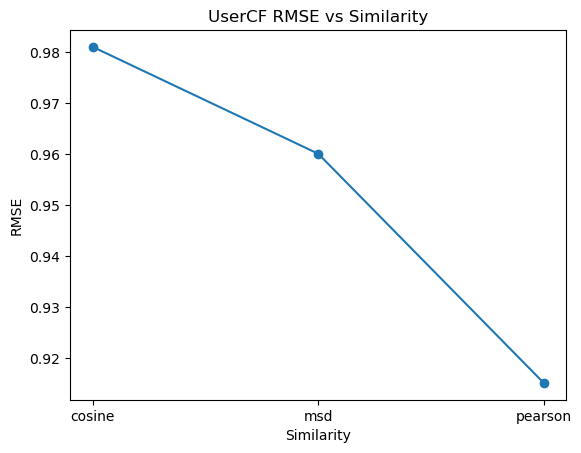

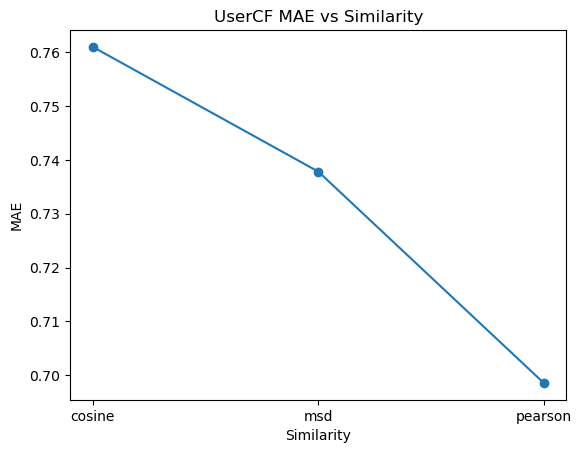

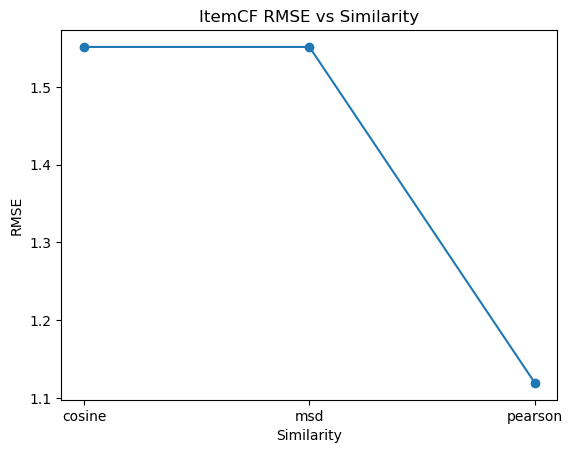

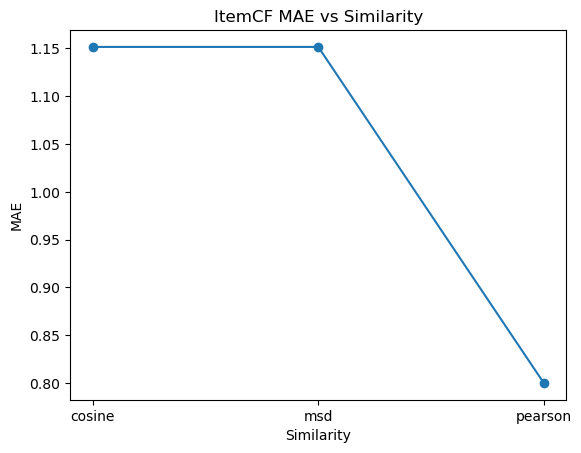

,K,rmse,mae
0,5,0.960547,0.739094
1,10,0.930136,0.712444
2,20,0.918028,0.701681
3,30,0.915568,0.699327
4,40,0.915125,0.698596
5,60,0.914831,0.698351
6,80,0.914537,0.698334
7,100,0.914220,0.698338


,K,rmse,mae
0,5,1.181269,0.861126
1,10,1.148148,0.829146
2,20,1.129343,0.810426
3,30,1.122712,0.803689
4,40,1.119216,0.800140
5,60,1.116558,0.797635
6,80,1.115419,0.796924
7,100,1.115490,0.797131


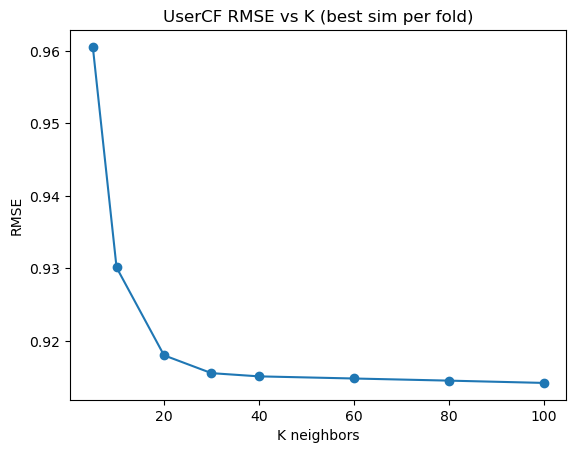

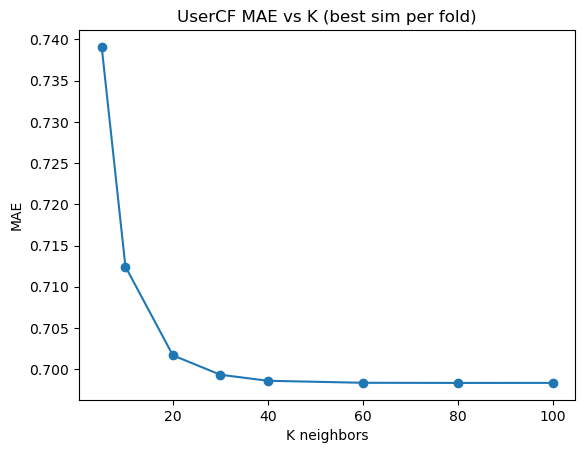

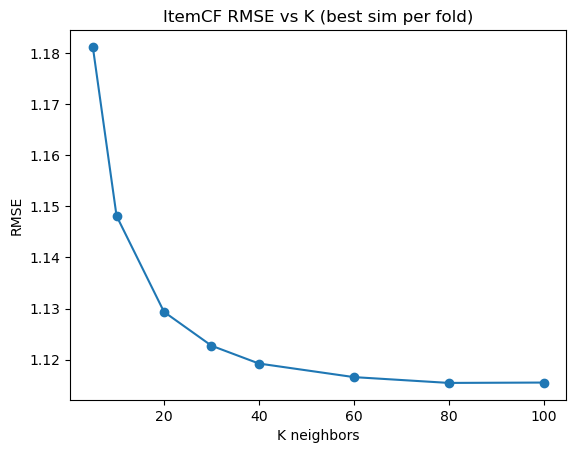

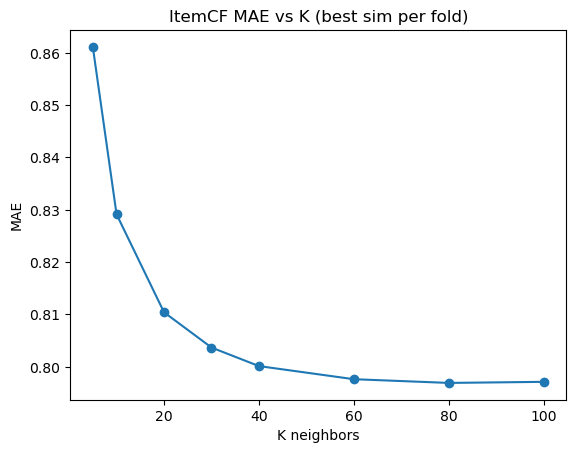

✅ Done. Tables and plots are above; CSVs/summary are saved in: out


In [23]:
# ---------- Run ----------
df = load_ratings(RATINGS_CSV)
print(f"Loaded {len(df)} rows from: {RATINGS_CSV}")
display(df.head(10))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rows = []; sim_user_rows=[]; sim_item_rows=[]; neigh_user_rows=[]; neigh_item_rows=[]

for fold, (tr_idx, te_idx) in enumerate(kf.split(df), start=1):
    tr = df.iloc[tr_idx].copy(); te = df.iloc[te_idx].copy()
    te = te[ te['userID'].isin(tr['userID'].cat.categories) & te['movieID'].isin(tr['movieID'].cat.categories) ]
    umap, imap, nU, nI = build_maps(tr)
    Rtr, Rte = to_train_test_structs(tr, te, umap, imap)
    y_true = np.array([r for _,_,r in Rte], dtype=np.float32)

    train_pairs = [(u,i,r) for u,items in Rtr.items() for i,r in items.items()]
    P,Q,bu,bi,mu = pmf_sgd(train_pairs, nU, nI, n_factors=20, n_epochs=15, lr=0.01, reg=0.05, seed=fold)
    y_pred_pmf = pmf_predict(P,Q,bu,bi,mu,Rte)
    cv_rows.append({'fold':fold,'model':'PMF','rmse':rmse(y_true,y_pred_pmf),'mae':float(mean_absolute_error(y_true,y_pred_pmf))})

    y_pred_user = predict_knn(Rtr, Rte, axis='user', sim_name='msd', K=40)
    cv_rows.append({'fold':fold,'model':'UserCF (MSD)','rmse':rmse(y_true,y_pred_user),'mae':float(mean_absolute_error(y_true,y_pred_user))})
    y_pred_item = predict_knn(Rtr, Rte, axis='item', sim_name='msd', K=40)
    cv_rows.append({'fold':fold,'model':'ItemCF (MSD)','rmse':rmse(y_true,y_pred_item),'mae':float(mean_absolute_error(y_true,y_pred_item))})

    for s in ['cosine','msd','pearson']:
        yp = predict_knn(Rtr, Rte, axis='user', sim_name=s, K=40)
        sim_user_rows.append({'fold':fold,'similarity':s,'rmse':rmse(y_true,yp),'mae':float(mean_absolute_error(y_true,yp))})
        yp = predict_knn(Rtr, Rte, axis='item', sim_name=s, K=40)
        sim_item_rows.append({'fold':fold,'similarity':s,'rmse':rmse(y_true,yp),'mae':float(mean_absolute_error(y_true,yp))})

    tmpu = pd.DataFrame([r for r in sim_user_rows if r['fold']==fold])
    best_sim_user = tmpu.iloc[tmpu['rmse'].astype(float).idxmin()]['similarity']
    tmpi = pd.DataFrame([r for r in sim_item_rows if r['fold']==fold])
    best_sim_item = tmpi.iloc[tmpi['rmse'].astype(float).idxmin()]['similarity']

    for K in [5,10,20,30,40,60,80,100]:
        yp = predict_knn(Rtr, Rte, axis='user', sim_name=best_sim_user, K=K)
        neigh_user_rows.append({'fold':fold,'K':K,'rmse':rmse(y_true,yp),'mae':float(mean_absolute_error(y_true,yp)),'similarity':best_sim_user})
        yp = predict_knn(Rtr, Rte, axis='item', sim_name=best_sim_item, K=K)
        neigh_item_rows.append({'fold':fold,'K':K,'rmse':rmse(y_true,yp),'mae':float(mean_absolute_error(y_true,yp)),'similarity':best_sim_item})

# (c,d) tables
cv_df = pd.DataFrame(cv_rows)
agg = cv_df.groupby('model').agg(rmse_mean=('rmse','mean'), rmse_std=('rmse','std'),
                                 mae_mean=('mae','mean'),   mae_std=('mae','std')).reset_index()
display(cv_df)
display(agg)
cv_df.to_csv(os.path.join(OUT_DIR,'cv_folds.csv'), index=False)
agg.to_csv(os.path.join(OUT_DIR,'cv_overview.csv'), index=False)

best_rmse_model = agg.iloc[agg['rmse_mean'].astype(float).idxmin()]['model']
best_mae_model  = agg.iloc[agg['mae_mean'].astype(float).idxmin()]['model']
print(f"Best by RMSE: {best_rmse_model}")
print(f"Best by MAE : {best_mae_model}")

# (e) similarity impact
su = pd.DataFrame(sim_user_rows).groupby('similarity').agg(rmse=('rmse','mean'), mae=('mae','mean')).reset_index()
si = pd.DataFrame(sim_item_rows).groupby('similarity').agg(rmse=('rmse','mean'), mae=('mae','mean')).reset_index()
display(su); display(si)
su.to_csv(os.path.join(OUT_DIR,'similarity_user.csv'), index=False)
si.to_csv(os.path.join(OUT_DIR,'similarity_item.csv'), index=False)

# (e) plots
plot_xy(su['similarity'], su['rmse'], 'UserCF RMSE vs Similarity', 'Similarity', 'RMSE')
plot_xy(su['similarity'], su['mae'],  'UserCF MAE vs Similarity',  'Similarity', 'MAE')
plot_xy(si['similarity'], si['rmse'], 'ItemCF RMSE vs Similarity', 'Similarity', 'RMSE')
plot_xy(si['similarity'], si['mae'],  'ItemCF MAE vs Similarity',  'Similarity', 'MAE')

# (f,g) neighbors
nu = pd.DataFrame(neigh_user_rows).groupby('K').agg(rmse=('rmse','mean'), mae=('mae','mean')).reset_index()
ni = pd.DataFrame(neigh_item_rows).groupby('K').agg(rmse=('rmse','mean'), mae=('mae','mean')).reset_index()
display(nu); display(ni)
nu.to_csv(os.path.join(OUT_DIR,'neighbors_user.csv'), index=False)
ni.to_csv(os.path.join(OUT_DIR,'neighbors_item.csv'), index=False)

plot_xy(nu['K'], nu['rmse'], 'UserCF RMSE vs K (best sim per fold)', 'K neighbors', 'RMSE')
plot_xy(nu['K'], nu['mae'],  'UserCF MAE vs K (best sim per fold)',  'K neighbors', 'MAE')
plot_xy(ni['K'], ni['rmse'], 'ItemCF RMSE vs K (best sim per fold)', 'K neighbors', 'RMSE')
plot_xy(ni['K'], ni['mae'],  'ItemCF MAE vs K (best sim per fold)',  'K neighbors', 'MAE')

with open(os.path.join(OUT_DIR,'best_summary.txt'),'w') as f:
    f.write("=== Cross-Validation Overview (c,d) ===\n")
    f.write(agg.to_string(index=False))
    f.write("\n\nBest by RMSE: %s\n" % best_rmse_model)
    f.write("Best by MAE : %s\n" % best_mae_model)
    f.write("\n=== Similarity Impact (e) ===\n")
    f.write("See similarity_user.csv / similarity_item.csv and the inline plots.\n")
    f.write("\n=== Neighbor Sweep (f,g) ===\n")
    f.write("See neighbors_user.csv / neighbors_item.csv and the inline plots.\n")

print("✅ Done. Tables and plots are above; CSVs/summary are saved in:", OUT_DIR)